lmfit Version
===

Extracting a signal from two datasets.
---
Below we simulate two experiments.

Experiment1:
- has a gaussian signal
- and a falling background that goes as $exp^{-x/\lambda}$

Experinemt2:
- has the same gaussian signal component
- and a background that goes as $x^n$, where $n$<0

In [1]:
import numpy as np
from lmfit import minimize, Parameters
import matplotlib.pyplot as plt

In [2]:
# we'll use ROOT rot his par b/c it's easier, but return numpy arrays instead of histograms
import ROOT as r

tfsig=r.TF1("tfsig","exp(-0.5*(x-[0])*(x-[0])/[1]/[1])",25,125)
tfsig.SetParameters(75,4.5)

# a basic function to convert ROOT histograms into numpy arrays
def hist2np(h):
    nbin=h.GetNbinsX()
    x=np.zeros(nbin)
    y=np.zeros(nbin)
    ey=np.zeros(nbin)
    for i in range(1,nbin+1):  # bin index is 1..N
        x[i-1]=h.GetBinCenter(i)
        y[i-1]=h.GetBinContent(i)
        ey[i-1]=h.GetBinError(i)
    return x,y,ey

def experiment1():
    S_over_N = 0.08
    ndata=2700
    lam=20
    range=(30,100)
    background = r.TF1("back1","exp(-x/[0])",range[0],range[1])
    background.SetParameter(0,lam)
    hist = r.TH1F("hexp1","Experiment1;x;frequency",50,range[0],range[1])
    nsig=int(ndata*S_over_N)
    nbkg=ndata-nsig
    hist.FillRandom("tfsig",nsig)
    hist.FillRandom("back1",nbkg)
    return hist2np(hist)

def experiment2():
    S_over_N = 0.12
    ndata=2500   
    n=-2.2
    range=(50,100)
    background = r.TF1("back2","pow(x,[0])",range[0],range[1])
    background.SetParameter(0,n)
    hist = r.TH1F("hexp2","Experiment2;x;frequency",50,range[0],range[1])
    nsig=int(ndata*S_over_N)
    nbkg=ndata-nsig
    hist.FillRandom("tfsig",nsig)
    hist.FillRandom("back2",nbkg)
    return hist2np(hist)

In [3]:
x1,y1,e1=experiment1()
x2,y2,e2=experiment2()

<ErrorbarContainer object of 3 artists>

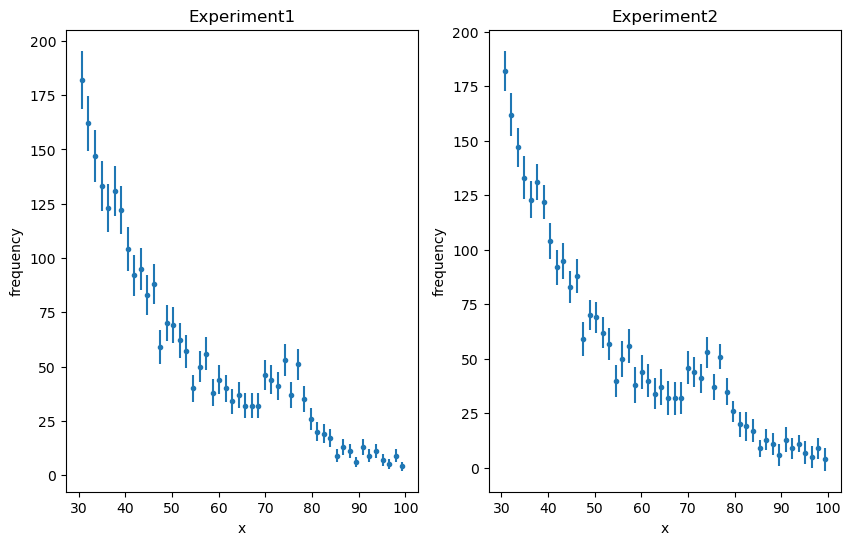

In [4]:
# Plot the histogram data with error bars
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.set_title('Experiment1')
ax1.set_xlabel('x')
ax1.set_ylabel('frequency')

ax2.set_title('Experiment2')
ax2.set_xlabel('x')
ax2.set_ylabel('frequency')

ax1.errorbar(x1, y1, yerr=e1, fmt='.')
ax2.errorbar(x1, y1, yerr=e2, fmt='.')


You job for this project will be to develop a simultaneous fit for the two histograms using minuit.  See this week's exercise description for more details.

In [5]:
bin_centers = [x1, x2]
counts = [y1, y2]
errs = [e1, e2]


In [6]:
def fit1(x, norm, mu, sigma, A, k):
    return norm*np.exp(-0.5*(x-mu)**2/sigma**2) + A*np.exp(-k*x)

def fit2(x, norm, mu, sigma, A, n):
    return norm*np.exp(-0.5*(x-mu)**2/sigma**2) + A*np.pow(x,n)

def objective(params, x, data, errs):
    mu = params['mu']
    sigma = params['sigma']
    norm1 = params['norm1']
    norm2 = params['norm2']
    A1 = params['A1']
    A2 = params['A2']
    k1 = params['k1']
    n = params['n']
    
    model1 = fit1(x[0], norm1, mu, sigma, A1, k1)
    model2 = fit2(x[1], norm2, mu, sigma, A2, n)

    res1 = []
    res2 = []

    for i in range(len(errs[0])):
        if errs[0][i] == 0:
            continue
        res1.append((model1[i] - data[0][i]) / errs[0][i])

    for i in range(len(errs[1])):
        if errs[1][i] == 0:
            continue
        res2.append((model2[i] - data[1][i]) / errs[1][i])

    #res1 = (model1 - data[0]) / errs[0]
    #res2 = (model2 - data[1]) / errs[1]
    return np.sqrt(np.pow(res1,2)+np.pow(res2,2))

params = Parameters()
params.add('mu', value=75)
params.add('sigma', value=5)
params.add('norm1', value=40)
params.add('norm2', value=20)
params.add('A1', value=1550)
params.add('A2', value=250000)
params.add('k1', value=1/15)
params.add('n', value=-2)


In [7]:
result = minimize(objective, params, args=(bin_centers, counts, errs))

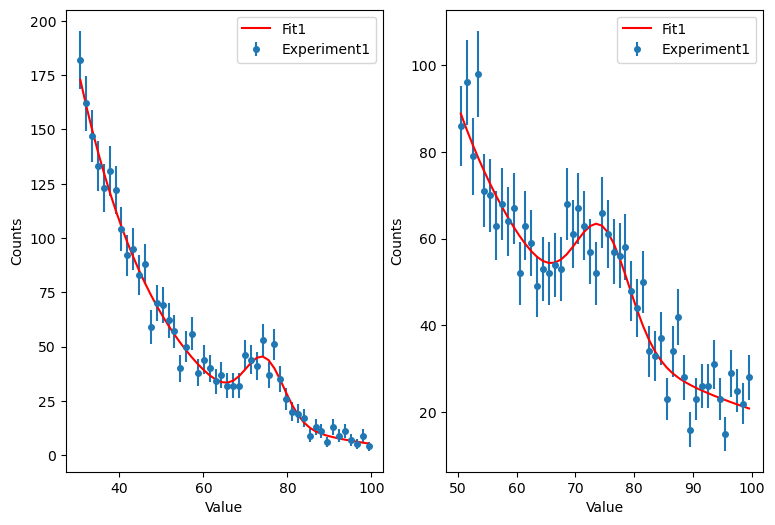

In [8]:
fit1 = fit1(bin_centers[0], result.params['norm1'].value, result.params['mu'].value, result.params['sigma'].value, result.params['A1'].value, result.params['k1'].value)

fit2 = fit2(bin_centers[1], result.params['norm2'].value, result.params['mu'].value, result.params['sigma'].value, result.params['A2'].value, result.params['n'].value)

fig, ax = plt.subplots(1,2, figsize=[9,6])

ax[0].errorbar(bin_centers[0], counts[0], yerr=errs[0], fmt='o', label='Experiment1', markersize=4)
ax[0].plot(bin_centers[0], fit1, 'r-', label='Fit1')
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Counts")
ax[0].legend()

ax[1].errorbar(bin_centers[1], counts[1], yerr=errs[1], fmt='o', label='Experiment1', markersize=4)
ax[1].plot(bin_centers[1], fit2, 'r-', label='Fit1')
ax[1].set_xlabel("Value")
ax[1].set_ylabel("Counts")
ax[1].legend()
plt.savefig("ex2.pdf")

In [9]:
print(f"Mean value: {result.params['mu'].value} +- {result.params['mu'].stderr}")
print(f"Sigma value: {result.params['sigma'].value} +- {result.params['sigma'].stderr}")

print(f"Chi^2 value: {result.chisqr}")
print(f"ndof value: {result.nfree}")
print(f"Reduced Chi^2: {result.redchi}")

Mean value: 74.6033420951343 +- 1.0771691516945787
Sigma value: 4.595751168835847 +- 1.0396558146926151
Chi^2 value: 76.16762841973454
ndof value: 42
Reduced Chi^2: 1.8135149623746318
